In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import xarray as xr
import cartopy.crs as ccrs
from os import path
from pyresample.geometry import AreaDefinition
from pyresample.geometry import GridDefinition
from pyresample import image, geometry, load_area, save_quicklook, SwathDefinition, area_def2basemap
from pyresample.kd_tree import resample_nearest
from scipy import spatial
sys.path.append('../saildrone/subroutines/')
from read_routines import read_all_usv, read_one_usv,add_coll_vars,get_filelist_l2p,get_orbital_data_l2p
from read_routines import add_coll_vars_ds_jplrss
import warnings
warnings.simplefilter('ignore') # filter some warning messages
from glob import glob

In [10]:
if path.exists('f:/data/'):
    print('yes')

yes


In [2]:
dir_data = 'C:/Users/gentemann/Google Drive/public/ALL_Saildrone_Data/' #'f:/data/cruise_data/saildrone/saildrone_data/'
dir_data_pattern = 'C:/Users/gentemann/Google Drive/public/ALL_Saildrone_Data/*west*.nc' 
#dir_data 'f:/data/cruise_data/saildrone/saildrone_data/'
#dir_data_pattern = 'f:/data/cruise_data/saildrone/saildrone_data/*.nc'

#get list of all filenames in directory
files = glob(dir_data_pattern)
print('number of file:',len(files))
#for ifile,file in enumerate(files):
#    print(ifile,file)
ds_usv = xr.open_dataset(files[4]).rename({'latitude':'lat','longitude':'lon'})


number of file: 13


In [3]:
ds_usv,name_usv = read_one_usv(files[0])
usv_day = ds_usv.time[0]
filelist_jpl = get_filelist_l2p(0, usv_day)
filelist_rss = get_filelist_l2p(1, usv_day)

file=filelist_jpl[0]
ii = file.find('_r')
iorb = int(file[ii+2:ii+7])
file_rss=[tem for tem in filelist_rss if str(iorb) in tem]
ds = xr.open_dataset(filelist_jpl[0])
ds['cellon'] = (ds['cellon'] + 180) % 360 - 180
ds.close()
ds2 = xr.open_dataset(file_rss[0])
ds2.close()


In [4]:
print()

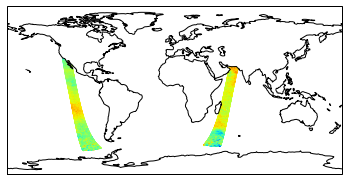

In [5]:
x = ds.cellon.data
y = ds.cellat.data
z = ds.sss_smap.data
ax = plt.axes(projection=ccrs.PlateCarree())
cs1 = ax.scatter(x, y, s=1.0, c=z, edgecolor='none', cmap='jet')
#minlon,maxlon,minlat,maxlat = ds_usv.lon.min().data,ds_usv.lon.max().data,ds_usv.lat.min().data,ds_usv.lat.max().data
#ax.plot([minlon,maxlon,maxlon,minlon,minlon],[minlat,minlat,maxlat,maxlat,minlat])
#ax.plot(ds_usv.lon,ds_usv.lat,'ro')
ax.coastlines()
#ax.set_xlim(-130,-100)
#ax.set_ylim(20,40)

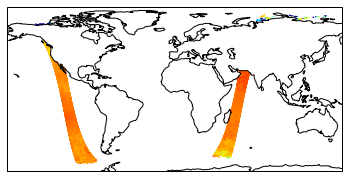

In [6]:
x = ds2.lon.data
y = ds2.lat.data
z = ds2.smap_sss.data
ax = plt.axes(projection=ccrs.PlateCarree())
cs1 = ax.scatter(x, y, s=1.0, c=z, edgecolor='none', cmap='jet')
#minlon,maxlon,minlat,maxlat = ds_usv.lon.min().data,ds_usv.lon.max().data,ds_usv.lat.min().data,ds_usv.lat.max().data
#ax.plot([minlon,maxlon,maxlon,minlon,minlon],[minlat,minlat,maxlat,maxlat,minlat])
#ax.plot(ds_usv.lon,ds_usv.lat,'ro')
ax.coastlines()
#ax.set_xlim(-130,-100)
#ax.set_ylim(20,40)

# Read in All Saildrone cruises downloaded from https://data.saildrone.com/data/sets
- 2017 onwards, note that earlier data is going to lack insruments and be poorer data quality in general
- For this code I want to develop a routine that reads in all the different datasets and creates a standardized set
- It may work best to first read each of the files individually into a dictionary 
- then go through each dataset finding all variable names
- I decided to put all SST into TEMP_CTD_MEAN and same for Salinity so there is a single variable name
- this still preserves all the dataset information

In [7]:
dir_data = 'C:/Users/gentemann/Google Drive/public/ALL_Saildrone_Data/' #'f:/data/cruise_data/saildrone/saildrone_data/'
dir_data_pattern = 'C:/Users/gentemann/Google Drive/public/ALL_Saildrone_Data/*west*.nc' 
#dir_data 'f:/data/cruise_data/saildrone/saildrone_data/'
#dir_data_pattern = 'f:/data/cruise_data/saildrone/saildrone_data/*.nc'

#get list of all filenames in directory
files = [x for x in glob(dir_data_pattern)]
print('number of file:',len(files))
for ifile,file in enumerate(files):
    print(ifile,file)


number of file: 13
0 C:/Users/gentemann/Google Drive/public/ALL_Saildrone_Data\saildrone_west_coast_survey_2018_sd1024.nc
1 C:/Users/gentemann/Google Drive/public/ALL_Saildrone_Data\saildrone_west_coast_survey_2018_sd1025.nc
2 C:/Users/gentemann/Google Drive/public/ALL_Saildrone_Data\saildrone_west_coast_survey_2018_sd1026.nc
3 C:/Users/gentemann/Google Drive/public/ALL_Saildrone_Data\saildrone_west_coast_survey_2018_sd1027.nc
4 C:/Users/gentemann/Google Drive/public/ALL_Saildrone_Data\saildrone_west_coast_survey_2018_sd1028.nc
5 C:/Users/gentemann/Google Drive/public/ALL_Saildrone_Data\saildrone_west_coast_survey_2019_sd1038.nc
6 C:/Users/gentemann/Google Drive/public/ALL_Saildrone_Data\saildrone_west_coast_survey_2019_sd1039.nc
7 C:/Users/gentemann/Google Drive/public/ALL_Saildrone_Data\saildrone_west_coast_survey_2019_sd1040.nc
8 C:/Users/gentemann/Google Drive/public/ALL_Saildrone_Data\saildrone_west_coast_survey_2019_sd1043.nc
9 C:/Users/gentemann/Google Drive/public/ALL_Saildrone

## An example showing how the using matplotlib maps orbital data quickly and easily


In [8]:
#ds_tem = xr.open_dataset('C:/Users/gentemann/Google Drive/public/2019_saildrone/saildrone_arctic_sd1037_2019.nc')
#ds_tem2 = xr.open_dataset('f:/data/cruise_data/saildrone/2019_arctic/post_mission/saildrone-gen_5-arctic_misst_2019-sd1037-20190514T230000-20191011T183000-1_minutes-v1.1575487464625.nc')
#ds_tem = ds_tem.isel(row=slice(60,-1))
#ds_tem2 = ds_tem2.isel(obs=slice(60*24,-1))
#print(ds_tem.time[0].data,ds_tem.time[-1].data)
#print(ds_tem2.time[0,0].data,ds_tem2.time[0,-1].data)
#ds
#ds_usv

(25.0, 40.0)

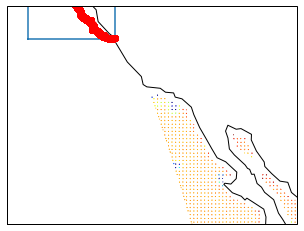

In [9]:
adir = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/'
ds_usv = xr.open_dataset(files[4]).rename({'latitude':'lat','longitude':'lon'})
#file = 'F:/data/sat_data/smap/SSS/L2/JPL/V4.3/2016/002/SMAP_L2B_SSS_04909_20160102T044855_R16010_V4.3.h5'
file = 'F:/data/sat_data/smap/SSS/L2/RSS/V3/40km/2018/115/RSS_SMAP_SSS_L2C_40km_r17250_20180425T004136_2018115_FNL_V03.0.nc'
ds = xr.open_dataset(file)
ds.close()
x = ds.cellon.data
y = ds.cellat.data
z = ds.sss_smap.data
ax = plt.axes(projection=ccrs.PlateCarree())
cs1 = ax.scatter(x, y, s=1.0, c=z, edgecolor='none', cmap='jet')
minlon,maxlon,minlat,maxlat = ds_usv.lon.min().data,ds_usv.lon.max().data,ds_usv.lat.min().data,ds_usv.lat.max().data
ax.plot([minlon,maxlon,maxlon,minlon,minlon],[minlat,minlat,maxlat,maxlat,minlat])
#ax.plot(ds.cellon[jj,ii],ds.cellat[jj,ii,0],'b*')
#ax.plot(ds_usv.lon[1000],ds_usv.lat[1000],'ro')
ax.plot(ds_usv.lon,ds_usv.lat,'ro')
ax.coastlines()
ax.set_xlim(-130,-110)
ax.set_ylim(25,40)

# test read in a file to look at dimension names

In [10]:
file = 'F:/data/sat_data/smap/SSS/L2/JPL/V4.3/2016/002/SMAP_L2B_SSS_04909_20160102T044855_R16010_V4.3.h5'
#file = 'F:/data/sat_data/smap/SSS/L2/RSS/V4/SCI/2018/115/RSS_SMAP_SSS_L2C_r17250_20180425T004136_2018115_FNL_V04.0.nc'
ds = xr.open_dataset(file,decode_cf=False)
ds

<xarray.Dataset>
Dimensions:               (phony_dim_0: 76, phony_dim_1: 1624, phony_dim_2: 4)
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2
Data variables:
    anc_dir               (phony_dim_0, phony_dim_1) float32 ...
    anc_spd               (phony_dim_0, phony_dim_1) float32 ...
    anc_sss               (phony_dim_0, phony_dim_1) float32 ...
    anc_sst               (phony_dim_0, phony_dim_1) float32 ...
    anc_swh               (phony_dim_0, phony_dim_1) float32 ...
    antazi_aft            (phony_dim_0, phony_dim_1) float32 ...
    antazi_fore           (phony_dim_0, phony_dim_1) float32 ...
    azi_aft               (phony_dim_0, phony_dim_1) float32 ...
    azi_fore              (phony_dim_0, phony_dim_1) float32 ...
    ice_concentration     (phony_dim_0, phony_dim_1) float32 ...
    inc_aft               (phony_dim_0, phony_dim_1) float32 ...
    inc_fore              (phony_dim_0, phony_dim_1) float32 ...
    land_fraction_aft     (phony_dim_0, phony_dim_1) float32 ...
    land_fraction_fore    (phony_dim_0, phony_dim_1) float32 ...
    lat                   (phony_dim_0, phony_dim_1) float32 ...
    lon                   (phony_dim_0, phony_dim_1) float32 ...
    n_h_aft               (phony_dim_0, phony_dim_1) uint8 ...
    n_h_fore              (phony_dim_0, phony_dim_1) uint8 ...
    n_v_aft               (phony_dim_0, phony_dim_1) uint8 ...
    n_v_fore              (phony_dim_0, phony_dim_1) uint8 ...
    nedt_h_aft            (phony_dim_0, phony_dim_1) float32 ...
    nedt_h_fore           (phony_dim_0, phony_dim_1) float32 ...
    nedt_v_aft            (phony_dim_0, phony_dim_1) float32 ...
    nedt_v_fore           (phony_dim_0, phony_dim_1) float32 ...
    num_ambiguities       (phony_dim_0, phony_dim_1) uint8 ...
    quality_flag          (phony_dim_0, phony_dim_1) uint16 ...
    row_time              (phony_dim_1) float32 ...
    smap_ambiguity_dir    (phony_dim_0, phony_dim_1, phony_dim_2) float32 ...
    smap_ambiguity_spd    (phony_dim_0, phony_dim_1, phony_dim_2) float32 ...
    smap_high_dir         (phony_dim_0, phony_dim_1) float32 ...
    smap_high_dir_smooth  (phony_dim_0, phony_dim_1) float32 ...
    smap_high_spd         (phony_dim_0, phony_dim_1) float32 ...
    smap_spd              (phony_dim_0, phony_dim_1) float32 ...
    smap_sss              (phony_dim_0, phony_dim_1) float32 ...
    smap_sss_uncertainty  (phony_dim_0, phony_dim_1) float32 ...
    tb_h_aft              (phony_dim_0, phony_dim_1) float32 ...
    tb_h_bias_adj         (phony_dim_0, phony_dim_1) float32 ...
    tb_h_fore             (phony_dim_0, phony_dim_1) float32 ...
    tb_v_aft              (phony_dim_0, phony_dim_1) float32 ...
    tb_v_bias_adj         (phony_dim_0, phony_dim_1) float32 ...
    tb_v_fore             (phony_dim_0, phony_dim_1) float32 ...
Attributes:
    REVNO:                       4909
    REV_START_YEAR:              2016
    REV_START_DAY_OF_YEAR:       2
    Number of Cross Track Bins:  76
    Number of Along Track Bins:  1624
    REV_START_TIME:              2016-002T04:48:55.000
    REV_STOP_TIME:               2016-002T06:27:22.000
    TB_CRID:                     R16010
    L1B_TB_LORES_ASC_FILE:       /mirror/opsLOM/PRODUCTS/L1B_TB/004/2016/01/0...
    L1B_TB_LORES_DEC_FILE:       /mirror/opsLOM/PRODUCTS/L1B_TB/004/2016/01/0...
    Delta TBH Fore Ascending:    4.4287
    Delta TBH Aft Ascending:     4.4287
    Delta TBV Fore Ascending:    3.07739
    Delta TBV Aft Ascending:     3.07739
    Delta TBH Fore Decending:    4.4287
    Delta TBH Aft Decending:     4.4287
    Delta TBV Fore Decending:    3.07739
    Delta TBV Aft Decending:     3.07739
    QS_ICEMAP_FILE:              /testbed/saline/fore/smap-ancillary/ice/NCEP...
    TB_FLAT_MODEL_FILE:          /home/fore/smap-sds/config/dat/LBandTBFlat-v...
    TB_ROUGH_MODEL_FILE:         /testbed/saline/fore/winds-salinity/tb-winds...
    ANC_U10_FILE:                /testbed/saline/akhayash/matchup/L2B/u10mg

# What lon range for satellite & insitu? are we going 0-360 or -180 to 180?

In [16]:
print(ds.cellon.min().data,ds.cellon.max().data)
print(ds_usv.lon.min().data,ds_usv.lon.max().data)

AttributeError: 'Dataset' object has no attribute 'cellon'

## First let's figure out what orbital files actually have data in our area of interest.  To do this, use the pyresample software

- read in the in situ data
- calculate the in situ min/max dates to know what files to check

Now we have our time of interest

- loop through the satellite data
- calculate the in situ min/max lat/lon on the same day to define a small box of interest
- use pyresample to map the data onto a predefined 0.1 deg resolution spatial grid
- subset the gridded map to the area of interest
- see if there is any valid data in that area
- if there is any valid data, go to next step

## Use the fast search kdtree which is part of pyresample software, but I think maybe comes originally from sci-kit-learn.

- read in the in situ data
- read in a single orbit of satellite data
- kdtree can't handle it when lat/lon are set to nan.  I frankly have no idea why there is orbital data for both the JPL and RSS products that have nan for the geolocation.  That isn't normal.  But, okay, let's deal with it.  
- stack the dataset scanline and cell positions into a new variable 'z'
- drop all variables from the dataset when the longitude is nan
- set up the tree
- loop through the orbital data
- only save a match if it is less than 0.25 deg distance AND time is less than any previous match
- save the satellite indices & some basic data onto the USV grid




In [11]:
def get_time_start_end(isat,ds):
    if isat==0:
        orbit_time = np.datetime64(ds.attrs['time_coverage_start'])-np.timedelta64(24,'h') #changed to 24 hr for sss
        orbit_time2 = np.datetime64(ds.attrs['time_coverage_end'])+np.timedelta64(24,'h')  
    if isat==1:
        orbit_time = ds.time[0].data-np.timedelta64(12,'h')
        orbit_time2 = ds.time[-1].data+np.timedelta64(12,'h')        
    return orbit_time,orbit_time2

area_def = load_area('areas.cfg', 'pc_world')
rlon=np.arange(-180,180,.1)
rlat=np.arange(90,-90,-.1)


In [19]:
iname = 1  #set number of cruise to process
#for isat in range(2):

ds_usv,name_usv = read_one_usv(files[iname])

ds_usv = add_coll_vars_ds_jplrss(ds_usv)
fileout_rss = 'F:/data/cruise_data/saildrone/sss/2sat_sss_collocations_orbital/'+name_usv+'jplv04.3_rssv04.0_orbital.nc'

#search usv data
minday,maxday = ds_usv.time[0],ds_usv.time[-1]
usv_day = minday
print(iname,name_usv)
print(minday.data,maxday.data)
while usv_day<=maxday:
    print(usv_day.data,maxday.data)
    ds_day = ds_usv.sel(time=slice(usv_day-np.timedelta64(1,'D'),usv_day+np.timedelta64(1,'D')))
    ilen = ds_day.time.size
    if ilen<1:   #don't run on days without any data
        usv_day += np.timedelta64(1,'D')
        continue
    minlon,maxlon,minlat,maxlat = ds_day.lon.min().data,ds_day.lon.max().data,ds_day.lat.min().data,ds_day.lat.max().data
    filelist_jpl = get_filelist_l2p(1, usv_day)
    filelist_rss = get_filelist_l2p(0, usv_day)
    x,y,z = [],[],[]
    for ifile,file in enumerate(filelist_jpl):
        ds = xr.open_dataset(file)
        ds.close()  
        ds = ds.rename({'row_time':'time','ice_concentration':'fice'})         

        #print('****************')
        #print(file)

        #find corresponding RSS file
        file=filelist_jpl[0]
        ii = file.find('SSS_')
        iorb = int(file[ii+4:ii+9])
        file_rss=[tem for tem in filelist_rss if str(iorb) in tem]

        ds2 = xr.open_dataset(file_rss[0])
        ds2.close()            
        #ds = ds.isel(look=0)
        ds2 = ds2.rename({'iqc_flag':'quality_flag','cellon':'lon','cellat':'lat','sss_smap':'smap_sss','sss_smap_40km':'smap_sss_40km','ydim_grid':'phony_dim_0','xdim_grid':'phony_dim_1'})
        ds2['lon']=np.mod(ds2.lon+180,360)-180  
        ds_rss = ds2

#first do a quick check using resample to project the orbit onto a grid 
#and quickly see if there is any data in the cruise area on that day
#if there is, then continue to collocation

        x = ds['lon'].fillna(-89).data 
        y = ds['lat'].fillna(-89).data 
        z = ds['smap_sss'].data 
        lons,lats,data = x,y,z 
        swath_def = SwathDefinition(lons, lats)

        # Resample swath to a fixed 0.01 x 0.01 grid, represented by the variable grid_def:
        # https://stackoverflow.com/questions/58065055/floor-and-ceil-with-number-of-decimals
        #changed to be just the region of the usv cruise to make grid even smaller (hopefully)
        #when working with global orbital data, work with usv BUT
        #when working with granules use ds instead of ds_usv so you just do granule region
        grid_def_lon_min, grid_def_lon_max = np.round(ds_day.lon.min().data - 0.5 * 10**(-2), 2), np.round(ds_day.lon.max().data + 0.5 * 10**(-2), 2)
        grid_def_lat_min, grid_def_lat_max = np.round(ds_day.lat.min().data - 0.5 * 10**(-2), 2), np.round(ds_day.lat.max().data + 0.5 * 10**(-2), 2)
        grid_def_lons, grid_def_lats = np.arange(grid_def_lon_min,grid_def_lon_max+0.1,0.1), np.arange(grid_def_lat_max,grid_def_lat_min-0.1,-0.1)
        grid_mesh_lons,grid_mesh_lats = np.meshgrid(grid_def_lons,grid_def_lats)

        # Since we have the lon and lat values for the area, we define a grid instead of an area:
        # https://pyresample.readthedocs.io/en/latest/geo_def.html#griddefinition
        grid_def = GridDefinition(lons=grid_mesh_lons,lats=grid_mesh_lats)

        result1 = resample_nearest(swath_def, data, grid_def, radius_of_influence=20000, fill_value=None)
        da = xr.DataArray(result1,name='sss',coords={'lat':grid_def_lats,'lon':grid_def_lons},dims=('lat','lon'))

        numdata = np.isfinite(da).sum()
        if numdata<1:
            continue

        #CREATE tree for JPL
        #stack xarray dataset then drop lon == nan
        ds2 = ds.stack(z=('phony_dim_0', 'phony_dim_1')).reset_index('z')
        #drop nan
        ds_drop = ds2.where(np.isfinite(ds2.lon),drop=True)
        lats = ds_drop.lat.data
        lons = ds_drop.lon.data
        inputdata = list(zip(lons.ravel(), lats.ravel()))
        tree = spatial.KDTree(inputdata)

        #CREATE tree for RSS
        #stack xarray dataset then drop lon == nan
        ds2 = ds_rss.isel(look=0).stack(z=('phony_dim_0', 'phony_dim_1')).reset_index('z')
        #drop nan
        ds_drop = ds2.where(np.isfinite(ds2.lon),drop=True)
        lats = ds_drop.lat.data
        lons = ds_drop.lon.data
        inputdata = list(zip(lons.ravel(), lats.ravel()))
        tree_rss = spatial.KDTree(inputdata)

        orbit_time, orbit_time2 = get_time_start_end(1,ds)

        cond = (ds_usv.time.data>orbit_time) & (ds_usv.time.data<orbit_time2)
        item = np.argwhere(cond)
        if item.sum()<1:  #no data within 12 hr of orbit
            continue
        for iusv_index in range(int(item[0]),int(item[-1])):
            pts = np.array([ds_usv.lon[iusv_index], ds_usv.lat[iusv_index]]) #pts = np.array([ds_usv.lon[iusv]+360
            tree.query(pts,k=1)
            i = tree.query(pts)[1]
            rdist = tree.query(pts)[0]                   
            if rdist>.25:    #don't use matchups more than 25 km away
                continue
            #use .where to find the original indices of the matched data point
            #find by matching sss and lat, just randomly chosen variables, you could use any
            result = np.where((ds.smap_sss == ds_drop.smap_sss[i].data) & (ds.lat == ds_drop.lat[i].data))
            listOfCoordinates = list(zip(result[0], result[1]))
            if len(listOfCoordinates)==0:
                continue
            ii, jj = listOfCoordinates[0][0],listOfCoordinates[0][1]
#                if isat==0:
#            deltaTa = ((ds_usv.time[iusv_index]-ds.time[ii,jj]).data)/ np.timedelta64(1,'m')
#                if isat==1:
            deltaTa = ((ds_usv.time[iusv_index]-ds.time[ii]).data)/ np.timedelta64(1,'m')
            if np.abs(deltaTa)<np.abs(ds_usv.deltaT[iusv_index].data):
                ds_usv.deltaT[iusv_index]=deltaTa
                ds_usv.smap_SSS_jpl[iusv_index]=ds.smap_sss[ii,jj]
                ds_usv.smap_rev_number_jpl[iusv_index]=int(ds.attrs['REVNO']) #int(ds.attrs['orbit_number'])
                ds_usv.smap_iqc_flag_jpl[iusv_index]=ds.quality_flag[ii,jj]
                ds_usv.smap_name_jpl[iusv_index]=str(file)
                ds_usv.smap_fice_jpl[iusv_index]=ds.fice[ii,jj]
                ds_usv.smap_dist_jpl[iusv_index]=rdist
                ds_usv.smap_ydim_jpl[iusv_index]=ii
                ds_usv.smap_xdim_jpl[iusv_index]=jj

                #match with JPL found, now get RSS data
                mlat = ds.lat[ii,jj]
                mlon = ds.lon[ii,jj]               
                
#                dist = ((ds_rss.lat.isel(look=0)-mlat)**2+(ds_rss.lon.isel(look=0)-mlon)**2)**.5
#                dd = ds_rss.isel(dist.argmin(dim=["phony_dim_1", "phony_dim_0"]))
                ds_usv.smap_SSS_rss_40km[iusv_index]=dd.smap_sss_40km.mean('look')                  
                ds_usv.smap_SSS_rss[iusv_index]=dd.smap_sss.mean('look')
                ds_usv.smap_iqc_flag_rss[iusv_index]=dd.quality_flag.mean('look')
                ds_usv.smap_fice_rss[iusv_index]=dd.fice
                ds_usv.smap_fland_rss[iusv_index]=dd.fland.mean('look')

    usv_day += np.timedelta64(1,'D')
ds_usv.to_netcdf(fileout)


1 saildrone_west_coast_survey_2018_sd1025
2018-06-27T00:02:00.000000000 2018-10-26T17:59:00.000000000
2018-06-27T00:02:00.000000000 2018-10-26T17:59:00.000000000
2018-06-28T00:02:00.000000000 2018-10-26T17:59:00.000000000
2018-06-29T00:02:00.000000000 2018-10-26T17:59:00.000000000
2018-06-30T00:02:00.000000000 2018-10-26T17:59:00.000000000
2018-07-01T00:02:00.000000000 2018-10-26T17:59:00.000000000
2018-07-02T00:02:00.000000000 2018-10-26T17:59:00.000000000
2018-07-03T00:02:00.000000000 2018-10-26T17:59:00.000000000
2018-07-04T00:02:00.000000000 2018-10-26T17:59:00.000000000
2018-07-05T00:02:00.000000000 2018-10-26T17:59:00.000000000
2018-07-06T00:02:00.000000000 2018-10-26T17:59:00.000000000
2018-07-07T00:02:00.000000000 2018-10-26T17:59:00.000000000
2018-07-08T00:02:00.000000000 2018-10-26T17:59:00.000000000


KeyboardInterrupt: 

In [22]:
%%time
dist = ((ds_rss.lat.isel(look=0)-mlat)**2+(ds_rss.lon.isel(look=0)-mlon)**2)**.5
dd = ds_rss.isel(dist.argmin(dim=["phony_dim_1", "phony_dim_0"]))


Wall time: 23.6 s


In [32]:
        ds2 = ds_rss.isel(look=0).stack(z=('phony_dim_0', 'phony_dim_1')).reset_index('z')
        #drop nan
        ds_drop = ds2.where(np.isfinite(ds2.lon),drop=True)
        lats = ds_drop.lat.data
        lons = ds_drop.lon.data
        inputdata = list(zip(lons.ravel(), lats.ravel()))
        tree_rss = spatial.KDTree(inputdata)


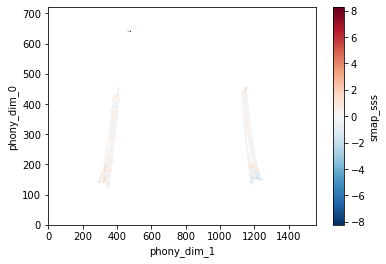

In [31]:
(ds_rss.smap_sss[:,:,0]-ds_rss.smap_sss[:,:,1]).plot()

In [23]:
%%time
tem = ds_rss.isel(look=0).sel(lat=slice(lat-1,lat+1),lon=slice(lon-1,lon+1))
dist = ((tem.lat-mlat)**2+(tem.lon-mlon)**2)**.5
dd = tem.isel(dist.argmin(dim=["phony_dim_1", "phony_dim_0"]))


NameError: name 'lat' is not defined

In [25]:
dist = ((ds2.lat.isel(look=0)-mlat)**2+(ds2.lon.isel(look=0)-mlon)**2)**.5

In [ ]:
#rename files from filesave4 to orbital since later I did 8day collocations as well, 
import os
dir_data_pattern = 'F:/data/cruise_data/saildrone/sss/2sat_sss_collocations_orbital_norepeat/*.nc' 
files = glob(dir_data_pattern)
print('number of file:',len(files))
for file in files:
    file2 = file.replace('filesave4','orbital')
    print(file,file2)
    os.rename(file,file2)